# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# added
from sklearn.cluster import KMeans
from sklearn import preprocessing

%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


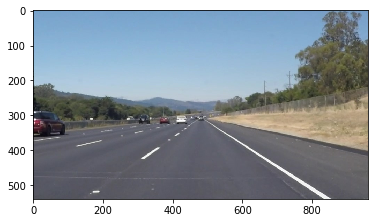

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math
import time
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    #return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  
    
def white_yellow_detection(img, low_y=[0, 140, 140], up_y=[100, 255, 255], low_w=[210, 210, 210], up_w=[255, 255, 255]):
    """inRange function to focus on white and yellow color"""

    # Convert BGR to HSV
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # define range of yellow color in HSV
    lower_yellow = np.array(low_y, dtype=np.uint8)
    upper_yellow = np.array(up_y, dtype=np.uint8)

    # Threshold the HSV image to get only yellow colors
    mask_y = cv2.inRange(hsv, lower_yellow, upper_yellow)

    # define range of white color in HSV
    lower_white = np.array(low_w, dtype=np.uint8)
    upper_white = np.array(up_w, dtype=np.uint8)

    # Threshold the BGR image to get only white colors
    mask_w = cv2.inRange(img, lower_white, upper_white)

    # Bitwise - AND mask and original image
    res_y = cv2.bitwise_and(img, img, mask=mask_y)
    res_w = cv2.bitwise_and(img, img, mask=mask_w)
    res_yw = cv2.bitwise_or(res_y, res_w)

    return res_yw

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform (Edge)"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel (Blur)"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[0, 255, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    if lines == None:
        pass
    else:
        for line in lines:
            for x1,y1,x2,y2 in line:
                cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def findmaxElem(cList, c_num):
    """
    find the most frequent element in clustering list.
    c_num is the nuber of the cluster, label starts from 0
    """
    cdict = {}
    for i in range(c_num):
        cdict[i] = 0
    for num in cList:
        cdict[num] += 1
    # sort by count
    d = [(v, k) for k, v in cdict.items()]
    d.sort()
    return(d[-1][1])

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    
    return line_img



def split_lines2LR(lines_list):
    """split lines_list = [[rho1, theta1], ..., [rho_n, theta_n]] to Left and Right"""
    l_lines = []
    r_lines = []
    for line in lines_list:
        rho, theta = line[0]
        if theta < math.pi /2.:
            l_lines.append( [rho, theta] )
        else:
            r_lines.append( [rho, theta] )
    return [l_lines, r_lines]


def fil_theta(theta_list, average, delta):
    """
    filter out the theta is outside of average +- delta
    delta needs ot be always positive
    return index that satisfies the condition
    """
    out = []
    for i, theta in enumerate(theta_list):
        if theta > (average-delta) and theta < (average + delta):
            out.append(i)
            
    return out

def fil_lines_by_theta(lines, theta_mean, theta_delta, direction):
    """ filter out the unreasonble angle data"""
    thetas = []
    for rho, theta in lines:
        thetas.append(theta)
    if direction == 'left':
        idxs = fil_theta(thetas, math.pi/2. - theta_mean, theta_delta) 
    elif direction == 'right':
        idxs = fil_theta(thetas, math.pi/2. + theta_mean, theta_delta)
    return [a for i,a in enumerate(lines) if i in idxs]

def hough_lines_pole(img, rho, theta, threshold):
    """
    `img` should be the output of a Canny transform.     
    Returns an image with hough lines drawn.
    """    
    # added the hough lines by rho and theta, prepare for the blank display
    lines = cv2.HoughLines(img, rho, theta, threshold)
    return lines

# global variables of the past left and right data for filter
past_l_line = [[0,0],[0,0],[0,0],[0,0],[0,0]]
past_r_line = [[0,0],[0,0],[0,0],[0,0],[0,0]]

def find_cluster_centroid(lines, direction, c_num=2):
    """apply k-means clustering and find the dominant cluster's centroid""" 
    
    if len(lines) == 0:
        if direction == 'left':
            rho, theta = past_l_line[3]
        elif direction == 'right':
            rho, theta = past_r_line[3]

    elif len(lines) < c_num:
        rho, theta = lines[0] # randomly assign for now
        
    else:       
        X = lines
        scaler = preprocessing.StandardScaler().fit(X)   # scaling
        X_s = scaler.transform(X)
        kmeans = KMeans(n_clusters=c_num, random_state=0).fit(X_s) 
        label_list = kmeans.labels_
        maxElem = findmaxElem(label_list, c_num)               # find the dominant cluster
        centroid = kmeans.cluster_centers_[maxElem] # find the centroid
        rho, theta = scaler.inverse_transform(centroid) # inverse transform the scaled value
            
    return [rho, theta]


def sma(line, direction):
    """apply simple moving average for smoothing"""
    if direction == 'left':
        past_l_line.pop(0) # remove the oldest data
        past_l_line.append(line) # insert new data
        line_tmp = past_l_line
    elif direction == 'right':
        past_r_line.pop(0) # remove the oldest data
        past_r_line.append(line) # insert new data
        line_tmp = past_r_line
        
    f_rho, f_theta = 0, 0
    for rho, theta in line_tmp:
        f_rho += rho / float(len(line_tmp))
        f_theta += theta / float(len(line_tmp))
    return [f_rho, f_theta]


def draw_line_rho_theta(img, rho, theta):
    """Given the rho and theta, simply right the line"""
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 2000*(-b))
    y1 = int(y0 + 2000*(a))
    x2 = int(x0 - 2000*(-b))
    y2 = int(y0 - 2000*(a))
    
    cv2.line(img,(x1,y1),(x2,y2),(255,0,0),7)

    return img


# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

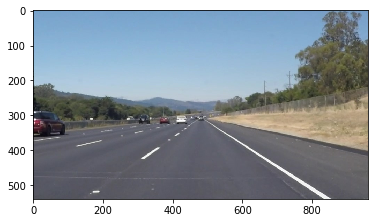

In [4]:
import os
#import glob
os.system('rm -f test_images/*_*')
os.listdir("test_images/")

# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

# set paramer
imshape = image.shape
xsize = imshape[1]
ysize = imshape[0]
plt.imshow(image)

In [5]:
def lineDetection(filepath, image):
    # target only yellow and white part
    wy_image = white_yellow_detection(image)

    # change to gray scale
    gray = grayscale(wy_image)

    # bluring
    blur = gaussian_blur(gray, 7)

    # edge detection
    low_threshold = 40
    high_threshold = 100
    edge = canny(blur, low_threshold, high_threshold)

    # masking
    x1, y1 = (0, ysize)
    x2, y2 = (xsize/2 - 40, ysize/2+40)
    x3, y3 = (xsize/2 + 40, ysize/2+40)
    x4, y4 = (xsize, ysize)
    vertices = np.array([[ (x1,y1), (x2, y2), (x3, y3), (x4, y4) ]], dtype=np.int32)
    mask = region_of_interest(edge, vertices)
    pts = np.array([[(x1, y1), (x2, y2), (x3, y3), (x4, y4)]], dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
    
    # lines - connecting lines by hough transformation
    rho   = 1                         # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180    # angular resolution in radians of the Hough grid
    threshold = 5                # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 30        # minimum number of pixels making up a line
    max_line_gap = 100   # maximum gap in pixels between connectable line segments
    line_image_cand = hough_lines(mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # lines - determined by rho and theta by hough transformation
    rho   = 1                         # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180    # angular resolution in radians of the Hough grid
    threshold = 75              # minimum number of votes (intersections in Hough grid cell)
    edge_lines_cand = canny(line_image_cand, low_threshold, high_threshold)
    lines = hough_lines_pole(edge_lines_cand, rho, theta, threshold)
    
    # devide to left and right line
    l_lines, r_lines = split_lines2LR(lines)
    
    # filter the outliers by rule base metho
    theta_mean = 0.55 # diff to pi/2.
    theta_delta = 0.2
    l_lines = fil_lines_by_theta(l_lines, theta_mean, theta_delta, 'left') # candidates
    r_lines = fil_lines_by_theta(r_lines, theta_mean, theta_delta, 'right') # candidates
    
    # clustering and find the dominant cluster's line
    l_line = find_cluster_centroid(l_lines, 'left', 2) # best line
    r_line = find_cluster_centroid(r_lines, 'right', 2)# best line

    # apply filter for smoothing, simple smoothing average
    #f_l_line = sma(l_line, 'left')
    #f_r_line = sma(r_line, 'right')

    # draw line 
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    line_img = draw_line_rho_theta(line_img, l_line[0], l_line[1])
    line_img = draw_line_rho_theta(line_img, r_line[0], r_line[1])
#    line_img = draw_line_rho_theta(line_img, f_l_line[0], f_l_line[1])
#    line_img = draw_line_rho_theta(line_img, f_r_line[0], f_r_line[1])
        
    # apply masking again to shoren the line
    line_image_final = region_of_interest(line_img, vertices)
        
    #  overlay the analyzed data on original image
    w_img = weighted_img(line_image_cand, image, α=0.8, β=1., λ=0.)        
    w_img = weighted_img(line_image_final, w_img, α=0.8, β=1., λ=0.)
    cv2.polylines(w_img, [pts], True, (0, 255, 255), 1)
    
    # write to external file
    cv2.imwrite(filepath[:-4] + '_line' + filepath[-4:], w_img)    
    
    # test plot
#    img1 = cv2.hconcat([wy_image, line_image1]) # color
#    img2 = cv2.hconcat([edge, edge_lines1]) # black and white
#    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2RGB) # gray 2 rgb
#    img3 = cv2.vconcat([img1, img2])
#    plt.imshow(img3)
#    plt.imshow(wy_image)    

    return w_img

# check all the test data
header = "test_images/"
datas = os.listdir("test_images/")
try:
    datas.remove('.DS_Store')
except:
    pass

for path in datas:
    filepath = header + path
    image = mpimg.imread(filepath)
    print(filepath)
    lineDetection(filepath, image)

test_images/solidWhiteCurve.jpg
test_images/solidWhiteRight.jpg


/Users/Yasu/.pyenv/versions/anaconda3-2.4.0/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:91: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


test_images/solidYellowCurve.jpg
test_images/solidYellowCurve2.jpg
test_images/solidYellowLeft.jpg
test_images/whiteCarLaneSwitch.jpg


## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here, mostly copied from above

    # set paramer
    imshape = image.shape
    xsize = imshape[1]
    ysize = imshape[0]
    
    # target only yellow and white part
    wy_image = white_yellow_detection(image)

    # change to gray scale
    gray = grayscale(wy_image)

    # bluring
    blur = gaussian_blur(gray, 7)

    # edge detection
    low_threshold = 40
    high_threshold = 100
    edge = canny(blur, low_threshold, high_threshold)

    # masking
    x1, y1 = (0, ysize)
    x2, y2 = (xsize/2 - 40, ysize/2+40)
    x3, y3 = (xsize/2 + 40, ysize/2+40)
    x4, y4 = (xsize, ysize)
    vertices = np.array([[ (x1,y1), (x2, y2), (x3, y3), (x4, y4) ]], dtype=np.int32)
    mask = region_of_interest(edge, vertices)
    pts = np.array([[(x1, y1), (x2, y2), (x3, y3), (x4, y4)]], dtype=np.int32)
    pts = pts.reshape((-1, 1, 2))
    
    # lines - connecting lines by hough transformation
    rho   = 1                         # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180    # angular resolution in radians of the Hough grid
    threshold = 5                # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 30        # minimum number of pixels making up a line
    max_line_gap = 100   # maximum gap in pixels between connectable line segments
    line_image_cand = hough_lines(mask, rho, theta, threshold, min_line_len, max_line_gap)
    
    # lines - determined by rho and theta by hough transformation
    rho   = 1                         # distance resolution in pixels of the Hough grid
    theta = 1*np.pi/180    # angular resolution in radians of the Hough grid
    threshold = 75              # minimum number of votes (intersections in Hough grid cell)
    edge_lines_cand = canny(line_image_cand, low_threshold, high_threshold)
    lines = hough_lines_pole(edge_lines_cand, rho, theta, threshold)
    
    # devide to left and right line
    l_lines, r_lines = split_lines2LR(lines)
    
    # filter the outliers by rule based method
    theta_mean = 0.55 # diff to pi/2.
    theta_delta = 0.2
    l_lines = fil_lines_by_theta(l_lines, theta_mean, theta_delta, 'left')
    r_lines = fil_lines_by_theta(r_lines, theta_mean, theta_delta, 'right')
    
    # clustering and find the dominant cluster's line (best line)
    l_line = find_cluster_centroid(l_lines, 'left', 2)   
    r_line = find_cluster_centroid(r_lines, 'right', 2)

    # apply filter for smoothing, simple smoothing average
    f_l_line = sma(l_line, 'left')
    f_r_line = sma(r_line, 'right')

    # draw line 
    line_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    line_img = draw_line_rho_theta(line_img, f_l_line[0], f_l_line[1])
    line_img = draw_line_rho_theta(line_img, f_r_line[0], f_r_line[1])

    # apply masking again to shoren the line
    line_image_final = region_of_interest(line_img, vertices)
        
    #  overlay the analyzed data on original image
    w_img = weighted_img(line_image_final, image, α=0.8, β=1., λ=0.)
#    w_img = weighted_img(line_image_cand, w_img, α=0.8, β=1., λ=0.)        
#    cv2.polylines(w_img, [pts], True, (0, 255, 255), 1)
    
    return w_img


Let's try the one with the solid white lane on the right first ...


In [8]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:13<00:00, 16.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 15 s, sys: 3.84 s, total: 18.9 s
Wall time: 13.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:40<00:00, 19.43it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 45.4 s, sys: 12.2 s, total: 57.6 s
Wall time: 40.5 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!m

In [12]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:20<00:00, 12.51it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 23.4 s, sys: 6.56 s, total: 30 s
Wall time: 21 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))

# 